# Uncertainty quantification

In this notebook, we exemplify an uncertainty quantification (UQ) method as outlined in the paper "Uncertainty quantification, propagation and characterization by Bayesian analysis combined with global sensitivity analysis applied to
dynamical intracellular pathway models" by Eriksson and Jauhiainen et al. 

The purpose of inverse uncertainty quantification is to estimate unknown parameters of a model from observed data, and at the same time quantify the uncertainty in these parameter estimates. We do this in a Bayesian framework by characterizing
the posterior distribution of the parameters via Approxiamte Bayesian Computation (ABC) coupled to Markov chain Monte Carlo (MCMC). 

The contents of this Notebook are licensed as: CC BY 4.0 (https://creativecommons.org/licenses/by/4.0/)


In [3]:
uqsaDirectory <- getwd()

## Prerequisites

In order to run this notebook, you need to have an R kernel installed, and the following packages installed within your R distribution (you may need to run `install.packages("[packageName]")` first):

In [4]:
# remotes::install_github("a-kramer/SBtabVFGEN")   # R package to generate vector field files from SBtab
# remotes::install_github("a-kramer/rgsl")         # R package to solve ODEs with the C library "gsl"
# remotes::install_github("icpm-kth/uqsa", subdir=c("UQ"))

# example of how to install an R package
# install.packages("VineCopula")

In [5]:
library(SBtabVFGEN)
library(rgsl)
library(uqsa)


library(deSolve)
library(reshape2)
library(ggplot2)

Loading required package: pracma

Loading required package: parallel

Loading required package: VineCopula

Loading required package: MASS

Loading required package: R.utils

Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.25.0 (2022-06-12 02:20:02 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.12.2 (2022-11-11 22:00:03 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, w

The R package with the functions that we implemented for UQ are available at https://github.com/icpm-kth/uqsa, in the UQ subfolder.
To install the package, the following lines of code can be used:

## The model

We show our uncertainty quantification toolset applied to the small model (here denoted by "AKAR4") describing the interaction between the reporter protein AKAR4 and PKA, which is a small part of the model presented in "AKAP79 enables calcineurin to directly suppress protein kinase A activity" (Church TW, Tewatia P, Hannan S, et al. Elife. 2021;10:e68164. Published 2021 Oct 6. doi:10.7554/eLife.68164).

In particular, we work with ordinary differential equation (ODE) models. In general, an ODE model is described by the following:

\begin{cases}
&\dot{\mathbf{x}}(t) &&= f(\mathbf{x}(t), \mathbf{u}(t), \mathbf{p}) \nonumber \\
&\mathbf{x}(t_0) &&=\mathbf{x_0} \label{eq:model}\\
&\mathbf{y}(t) &&= g(\mathbf{x}(t),\mathbf{s}) \nonumber
\end{cases}

where
- $\mathbf{x}(t)$ corresponds to internal state variables (compounds, in our case), 
- $\mathbf{u}(t)$ to external input (species concentrations that are controlled by experimentalists),
- $\mathbf{y}(t)$ are the outputs (measurements from experiments),
- $\mathbf{p}$ are system parameters (on which we want to perform UQ),
- $\mathbf{s}$ are parameters for the readouts.

The parameters $\mathbf{\theta}=(\mathbf{p}, \mathbf{s})$ together with the initial conditions $\mathbf{x}(t_0)$ and the input $\mathbf{u}(t)$ fully specify the output from the system.



We use SBtab to describe the model and store experimental data.
Basing on the SBtab format, we created a folder with all the spreadsheet files in .tsv extension.
The information about the model is contained in the tables of compounds, parameters, reactions, input (not present in this simple model) and output.

## Import model from SBtab into R

To import the model from the SBtab spreadsheet files (see: https://www.sbtab.net), we implemented the R function `import_from_SBtab`. 
The input to this function is the path of the directry where all the SBtab files (in .tsv extension) are stored.
The output is a list (here called `model`) containing all the information about the model.

In [6]:

SBtabDir <- paste0(uqsaDirectory,"/AKAR4") # write path of folder with all the SBtab (.tsv) files
model = import_from_SBtab(SBtabDir)
setwd(SBtabDir)


[tsv] file[1] «/home/aksll/uqsa/AKAR4/AKAR4_100nM.tsv» belongs to Document «AKAR4»
	I'll take this as the Model Name.




Here is some of the information that the list `model` contains.

In [7]:
model$Compound
model$Parameter
model$Reaction
model$Output
model$Experiments
model$AKAR4_400nM[1:10,]

!ID,!Name,!InitialValue,!Unit,!Location,!Identifiers:RRID,!Comment
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
AKAR4,AKAR4,0.2,micromole/liter,spine,RRID:Addgene_61619,AKAR4-8His-NES
AKAR4_C,AKAR4_C,0.0,micromole/liter,spine,NONE,NONE
AKAR4p,AKAR4p,0.0,micromole/liter,spine,NONE,NONE
C,C,0.0,micromole/liter,spine,NONE,catalytic subunit of PKA (UniProt ID:KAPCB_HUMAN)


!ID,!Name,!DefaultValue,!Std,!PriorDistribution,!Scale,!Unit
<chr>,<chr>,<dbl>,<lgl>,<chr>,<chr>,<chr>
kf_C_AKAR4,kf_C_AKAR4,0.018,NA,Uniform distribution,linear,1/(micromolarity*second)
kb_C_AKAR4,kb_C_AKAR4,0.106,NA,Uniform distribution,linear,1/second
kcat_AKARp,kcat_AKARp,10.200,NA,Uniform distribution,linear,1/second


!ID,!Name,!KineticLaw,!ReactionFormula,!IsReversible
<chr>,<chr>,<chr>,<chr>,<int>
reaction_1,reaction_1,kf_C_AKAR4*C*AKAR4 - kb_C_AKAR4*AKAR4_C,C + AKAR4 <=> AKAR4_C,1
reaction_2,reaction_2,kcat_AKARp*AKAR4_C,AKAR4_C <=> AKAR4p + C,0


!ID,!Name,!Formula,!Unit
<chr>,<chr>,<chr>,<chr>
AKAR4pOUT,AKAR4pOUT,AKAR4p,micromole/liter


!ID,!Name,>C,!Comment
<chr>,<chr>,<dbl>,<chr>
AKAR4_400nM,AKAR4_400nM,0.400,Figure 3—figure supplement 1 in https://doi.org/10.7554/eLife.68164 (dark blue)
AKAR4_100nM,AKAR4_100nM,0.100,Figure 3—figure supplement 1 in https://doi.org/10.7554/eLife.68164 (gray)
AKAR4_25nM,AKAR4_25nM,0.025,Figure 3—figure supplement 1 in https://doi.org/10.7554/eLife.68164 (light blue)


,!TimePoint,!Time,>AKAR4pOUT,>AKAR4pERR
,<chr>,<int>,<dbl>,<int>
1,E400T001,-15,108.600,1
2,E400T002,-10,111.350,1
3,E400T003,-5,108.750,1
4,E400T004,0,111.400,1
5,E400T005,5,111.700,1
6,E400T006,10,113.250,1
7,E400T007,15,117.000,1
8,E400T008,20,120.700,1
9,E400T009,25,121.475,1


When running function `import_from_SBtab`, the command-line program VFGEN is called (see: https://warrenweckesser.github.io/vfgen/index.html), and it is used to generate the files `[modelName].R`, `[modelName]_gfv.c` and `[modelName]_gfv.h`, that are located in the same folder as the SBtab spreadsheets. These files generated thrugh VFGEN contain the functions that implement the ODE vector field of the model.

In our example, the model name is "AKAR4" and the vector field function is saved in file "AKAR.R":

In [8]:
rFile<-paste0(SBtabDir,'/',comment(model),'.R')
cFile<-paste0(SBtabDir,'/',comment(model),'_gvf.c')
modelName <- checkModel(comment(model),cFile)
# modelName <- checkModel(comment(model),rFile)  # uncomment to use deSolve as backend

print(comment(modelName)) # the comment is either a compiled .so file, or the .R file, depending on backend 
                          # (users can set the comment directly, if they wish)

# load the R file with the vector field (regardless of which backend we chose, just to see the contents)
source(rFile)

# print the vector field function
AKAR4_vf

building a shared library from c source, and using GSL odeiv2 as backend (pkg-config is used here).

cc -shared -fPIC `pkg-config --cflags gsl` -o AKAR4.so /home/aksll/uqsa/AKAR4/AKAR4_gvf.c `pkg-config --libs gsl`



[1] "AKAR4.so"


function (t, state, parameters) 
{
    AKAR4 <- state[1]
    AKAR4_C <- state[2]
    AKAR4p <- state[3]
    C <- state[4]
    kf_C_AKAR4 <- parameters[1]
    kb_C_AKAR4 <- parameters[2]
    kcat_AKARp <- parameters[3]
    reaction_1 <- -kb_C_AKAR4 * AKAR4_C + AKAR4 * C * kf_C_AKAR4
    reaction_2 <- kcat_AKARp * AKAR4_C
    vf_ <- vector(len = 4)
    vf_[1] = -reaction_1
    vf_[2] = reaction_1 - reaction_2
    vf_[3] = reaction_2
    vf_[4] = -reaction_1 + reaction_2
    return(list(vf_))
}

The model exists in two files: an R file and a C file. They contain the same auto-generated content. The R file contains functions intended for use with deSolve. The C file (ending in `gvf.c`) contains functions for use with the GSL solvers (`gsl_odeiv2`). The user can select which simulation backend to use.

The choice of which simulator is chosen is made when `checkModel(modelName,modelFile=NULL)` is provided with a file (second slot, optional).

## Import experimental data from SBtab into R

Experimental data are also stored in the SBtab files. In particular, we created a table for each time series experiment, together with one table that summarized all the information about each experiment (i.e. initial conditions and input).

To import the experimental data we implemented the R function `import_experiments`, that requires as input the model name and the path of the folder with the .tsv files in the SBtab format. The output of `import_experiments` is a list, here denoted by `experiments`. Each element of this list corresponds to one experiment.

In this example, the experiments are time series data, that report the concentration of AKAR4 at several time points. 

In [9]:
experiments <- suppressMessages(import_experiments(modelName, SBtabDir))

# print first experiment
names(experiments[[1]])
print(experiments[[1]][["initialState"]])

[1] "initialState"   "input"          "outputTimes"    "outputNames"   
[5] "outputId"       "outputValues"   "outputFunction"

  AKAR4 AKAR4_C  AKAR4p       C 
    0.2     0.0     0.0     0.4 


# Uncertainty Quantification

## Define priors for parameters

We decided to use a log-uniform distribution for the parameters, centered in their default value (read from the SBtab) and with lower and upper limit, respectively, 1000-fold larger and smaller than the default value:

\[defaulParameter / 1000 ; defaultParameter * 1000\]


In [10]:
# default values of parameters
parVal <- model[["Parameter"]][["!DefaultValue"]]

# scale to determine the log uniform prior distribution
defRange <- 1000

# this function maps ABC sampling variables to acceptable model parameters
parMap <- function(parABC) {
 return(10^parABC)
}

ll <- parVal/defRange
ul <- parVal*defRange
ll = log10(ll) # log10-scale
ul = log10(ul) # log10-scale

## Define the ABC setting

We will perform the UQ applying the ABCMCMC algorithm in multiple steps.
At each step we consider the data from one of the three experiments that we read from the SBtab tables.

In [11]:
npc <- 1000    # number of samples for the Precalibration (npc) 
              # On a cluster, we can use 5000 or 50000.
delta <- 0.01 # Distance threshold to compare experimental data and simulated data
ns <- 5000    # number of points in sample

# Define the number of Cores for parallelized computations with mclapply
nCores <- detectCores() %/% 4

set.seed(123456)

Create a customized distance function

In [12]:
# Define the score function to compare simulated data with experimental data

getScore  <- function(yy_sim, yy_exp, yy_err=1){
  yy_sim <- (yy_sim-0)/(0.2-0.0)
  ifelse(!is.na(yy_exp), yy_exp <- (yy_exp-108.6)/(183.9-108.6), Inf)
  distance <- mean((yy_sim-yy_exp)^2)
  return(distance)
}

objectiveFunction <- makeObjective(experiments[c(1,2)], modelName, getScore, parMap)

## ABCMCMC

We start the uncertainty quantification by running the ABCMCMC algorithm with data from the first two experiments. We use the first two to show that more thanone experiment can be processed with one call, but don't use all data-sets to show that this process can be iterative if necessary: data may be obtained at a later data and added to the list. Previous results can be re-used. In this case we pretend that experiment 3 was performed later.

First, we create a uniform prior density function for all parameters using the lower limit and upper limit vectros. We also create a random vector generator that samples (independently) from the uniform distribution.

In [13]:
# select a uniform prior density function (priorPDF is a function)
priorPDF <- dUniformPrior(ll, ul)
priorRNG <- rUniformPrior(ll, ul)

We use the `preCalibration` and `getMCMCPar` functions to determine a starting parameter (`startPar`) for one or several parallel Markov chains (we use 1 chain here, but use thread based parallelization of simulations internally). We also calculate a covariance matrix (`Sigma`) for the MCMC transition kernel.

In [14]:
## Run Pre-Calibration Sampling
out1 <- preCalibration(objectiveFunction, npc, priorRNG)
  
## Get Starting Parameters from Pre-Calibration
out2 <- getMCMCPar(out1$prePar, out1$preDelta, delta=delta)
Sigma <- out2$Sigma
startPar <- out2$startPar
print(startPar)

[1] -1.5495295 -0.4277333  0.6230594


The ABCMCMC algorithm in `ABCMCMC` will be thread parallel. In addition `parLapply` could be use to simultaneously run several chains on multiple nodes (hosts) independently to increase the sample size. 

In [15]:
Sample<-ABCMCMC(objectiveFunction, startPar, ns, Sigma, delta, priorPDF)

Started chain.
Finished chain.


The output of `ABCMCMC` is a matrix, with parameter vectors stored row-wise: column *i* is a marginal sample for parameter *i*.

In [16]:
dim(Sample$draws)
head(Sample$draws)

[1] 5000    3

-0.8951376,1.2298347,0.4896305
-0.5325049,1.7509390,0.6564291
-1.5366467,1.0129034,1.1606649
-1.7898405,0.7916858,1.6021613
-1.3461523,0.8426671,0.9779251
-1.7296799,1.0882158,2.8180419


Each row of matrix `draws` corresponds to an ABC variable vector, if necessary they must be transformed by parMap() before the model can accept them. In simple cases where the ABC variables are the model parameters (unchanged) `parMap` is not needed (`runModel` will use `parMap` or the `identity` function if none is provided). When used in the ODE model, the draws produce simulations that are *close enough* to the experimental data. This is illustrated by the following plot, produced by function `plotDataAndSimulations`: for each parameter draw (row) produced by the ABCMCMC algorithm, we simulate the ODE system using the same initial conditions and input as the considered experiment (first experiment) and plot the simulated time series, together with the experimental data. This requires many simulations.

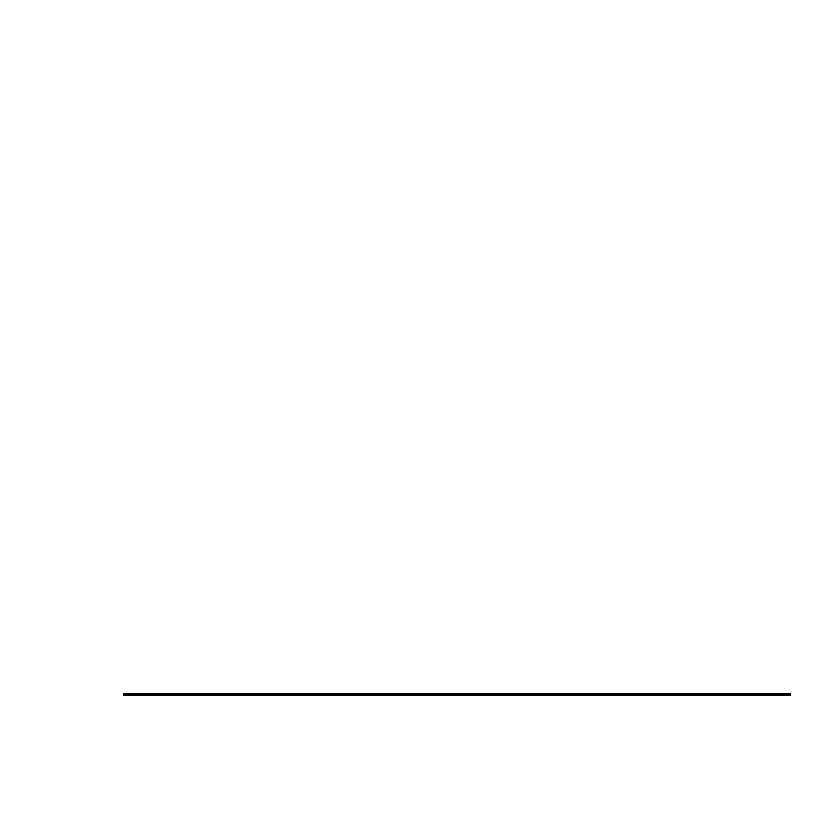

In [22]:
source(paste0(SBtabDir,"/plotFunctionsAKAR4.R"))

#plotDataAndSimulations(Sample$draws, experiments[1], parMap, nCores)
#plotDataAndSimulations(Sample$draws, experiments[2], parMap, nCores)
plotSample(Sample$draws, experiments[2], parMap, nCores)

The empirical distribution of parameter draws is an approximation of the posterior distribution the first two data-sets (experiments).

### Prediction

We have not used the data from the third experiment yet. But we can try to predict it based on the first two.

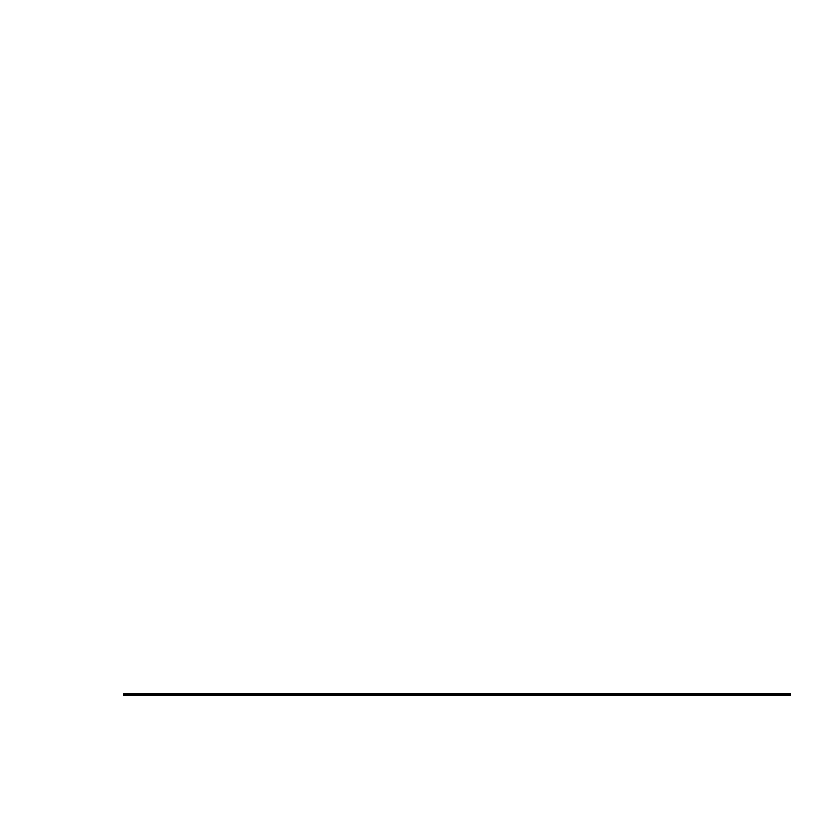

In [23]:
#plotDataAndSimulations(Sample$draws, experiments[3], parMap, nCores)
plotSample(Sample$draws, experiments[3], parMap, nCores)

We fit a copula based on the currently available posterior sample and use it as prior for the next step, where we will consider data from the third (pretend new) experiment.

In [28]:
#Fitting Copula based on previous MCMC runs
out <- fitCopula(Sample$draws)        
priorPDF<-dCopulaPrior(out)
priorRNG<-rCopulaPrior(out)
objectiveFunction <- makeObjective(experiments[3], modelName, getScore, parMap)
# example use of prior sampler:
print(priorRNG(10))

## Run Pre-Calibration Sampling
out1 <- preCalibration(objectiveFunction, npc, priorRNG)
out2 <- getMCMCPar(out1$prePar, out1$preDelta, delta=delta)
Sigma <- out2$Sigma
startPar <- out2$startPar

           [,1]        [,2]     [,3]
 [1,] -1.487951 -2.08823642 2.063335
 [2,] -1.786448  0.57953819 1.484833
 [3,] -1.745640 -0.95158149 2.435341
 [4,] -1.660098 -3.65327318 1.100937
 [5,] -1.568671  1.76975507 1.718400
 [6,] -1.292310 -0.03658948 1.892616
 [7,] -1.174863 -0.50871652 1.643956
 [8,] -1.776823  0.34029588 0.692322
 [9,] -1.802133 -3.21310973 3.478118
[10,] -1.158302  1.15380027 3.011609


In [ ]:
Sample<-ABCMCMC(objectiveFunction,startPar,ns,Sigma,delta,priorPDF)
draws<-Sample$draws

We use the draws, sampled through the ABCMCMC algorithm, to simulate trajectories.
We plot the trajectories (blue curves), together with the data from experiment 2 (black dots), using function `plotDataAndSimulations`.

In [ ]:
plotDataAndSimulations(draws, experiments[3], parMap, nCores)

The simulated time series agree with the experimental data from experiment 3 reasonably well.
This is of course not surprising, because we used data from experiment 3 in the ABCMCMC algorithm. The information from datasets 1 and 2 however were encoded only as a prior probability density estimate (which is not exact).

### Checking the Results for Consistency

To see whether the model still fits the earlier data we use the same ABC variable draws with the initial conditions from experiment 1 (we omit 2 for brevity here).

We simulate the model again, many times, to see whether these parameters still fit the first dataset (based on the prior alone).

In [ ]:
plotDataAndSimulations(draws, experiments[1], parMap, nCores)

*NOTE*: Some of the draws lead to simulated time series (blue curves) that are "too far" from the first experiment data. Hence, we filter out such draws using function `checkFitWithPreviousExperiments`.

In [ ]:
# Checking fit with dataset 1 and 2 (in one go)
draws <- checkFitWithPreviousExperiments(modelName, 
                                         draws, experiments[1:2], parMap, 
                                         getScore, delta, nCores)

In [ ]:
dim(draws)
head(draws)

We redo the plot after filtering.

In [ ]:
plotDataAndSimulations(draws, experiments[1], parMap, nCores)

In [ ]:
plotDataAndSimulations(draws, experiments[2], parMap, nCores)

We prceed with the uncertainty quantification and compare with the third dataset.

In [ ]:
plotDataAndSimulations(draws, experiments[3], parMap, nCores)

This is a good fit to all data-sets. 

## Plot final results 

In [ ]:
parNames <- model[["Parameter"]][["!Name"]]
# histograms 
par(mfrow=c(2,3))
for(i in 1:3){
  hist(draws[,i], main=parNames[i], xlab = "Value in log scale")
}

# scatterplot for pairs of parameters
combinePar <- list(c(1,2), c(1,3), c(2,3))
for(i in combinePar){
  plot(draws[,i[1]], draws[,i[2]], xlab = parNames[i[1]], ylab = parNames[i[2]])
}


# Additional information about the methods

## ABC-MCMC with copulas

In ABC, samples from a prior distribution (or a proposal distribution) are accepted if the experimental data are reproduced by simulations from the model within a certain margin, so that a distance measure $\rho(S(\mathbf{y}^{sim}),S(\mathbf{y}^\text{exp}))$ is smaller than some predefined cut-off $\delta$ (S is a summary statistic of the data). The accepted parameter sets $\mathbf{\theta}$ will form the approximate posterior distribution $f(\mathbf{\theta}|\rho(S(\mathbf{y}^\text{exp}),S(\mathbf{y}^{sim}))\leq\delta)$. 

We use a distance measure, or scoring function, that accounts for deviations on both the model output (y-axis) and model input (x-axis) since the experimental data may be subject to experimental error both regarding input and output.  

We couple ABC to Markov chain Monte Carlo (MCMC) to efficiently sample from the posterior distribution of the parameters of interest. The model is fitted to the datasets in sequence. In order to incorporate the information from each fit, we do the following:

* Fit the model to one datataset, producing a posterior distribution
* Fit a copula to the posterior distribution 
* Use the copula as a prior to fit the model to the next dataset

We use graphical models called R-vines to formulate copulas that are constructed in pairs in order to describe the dependencies over multiple parameters. 



### Copulas

Copulas are multivariate probability distributions which describe the dependence structure between stochastic variables. The copula is a function that connects the multivariate distribution function to the marginal ones ($F_i$) as follows.

$$
F(\mathbf{x}) = C(F_1(x_1), \ldots, F_d(x_d))
$$ 

It can be shown that the multivariate (joint) density can be represented by a number of appropriate pair-copulas times the conditional marginal densities based on a pair-copula factorization. For a distribution over three variables, we have

$$
f(x_1, x_2, x_3) = c_{1,2}(F_1(x_1),F_2(x_2))c_{2,3|1} (F(x_2|x_1), F(x_3|x_1))c_{1,3}(F_1(x_1), F_3(x_3))f_1(x_1) f_3 (x_3) f_2(x_2)\\
$$

The copula pairs can be chosen independently of each other giving a wide range of possible dependence structures. We use graphical models called R-vines to arrange the pair copulas in a tree structure. 

Let's assume we work with a simple bivariate distribution and that we have a bivariate sample $\mathbf{x}=[\mathbf{x}_1, \mathbf{x}_2]$. For each variable $X_1$ and $X_2$, we estimate a cumulative distribution $P(X_1 \leq x_1)$ and $P(X_2 \leq x_2)$ (this can be done in R using e.g. the kcde or ecdf functions). We evaluate these cumulative densities in the sample points $[\mathbf{x}_1, \mathbf{x}_2]$ and denote this information $\mathbf{z}=[\mathbf{z}_1, \mathbf{z}_2]$. This step maps the sample points ($\mathbf{x}$) into the $[0,1]$ space and we fit a copula to $\mathbf{z}$ in this space.




### Pre-calibration

Each fit to a dataset begins with a pre-calibration step, in order to construct a covariance matrix for the MCMC transition kernel as well as finding starting points for the MCMC chains.

In the pre-calibration step we sample independently from the prior distribution a number of times ($npc$) to produce a set of samples. We generate simulated output from the model for each parameter set and check, using the distance measure, how close the simulated outputs $\mathbf{y}^{sim}$are to the experimental data $\mathbf{y}^{exp}$. We save a certain fraction $p$ of the samples that have the smallest distances. With these samples, we estimate a covariance matrix that is used as transition kernel Q (scaled appropriately) for the MCMC chains. We also pick random starting points for the chains. 

In order to perform a streamlined computational pipeline, we always formulate the prior distribution of the parameters in the form of a copula. For the fit to the first dataset, when we have uniform independent priors for all parameters, we use an independece copula, where all copula pairs (i.e. pairs of parameters) are independent. 